# Bird Spices Face - Feature Visualization - VGG16 Model - TSNE
The intent with this notebook is to visualize the feature that the VGG16 model see through many of the models layers, using a pretrained VGG16 Model. Followed by Extracting the most intresting features with TSNE in order to get some visual representation of the differences between the images.

Dataset: [another anime face dataset](https://www.kaggle.com/datasets/gpiosenka/100-bird-species)

In [1]:
%pip install -q pip pydot matplotlib graphviz scikit-learn tensorflow[and-cuda]==2.14.1

Note: you may need to restart the kernel to use updated packages.


## Import all Modules and Configure GPU

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pathlib
import os.path
from sklearn.manifold import TSNE
from keras.models import Model

from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

import tensorflow as tf

# Initialize tf.distribute.MirroredStrategy
selected_devices = None #tf.config.list_logical_devices('CPU')
strategy = tf.distribute.MirroredStrategy(devices=selected_devices)
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))


2024-02-27 21:29:09.976483: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 21:29:09.976524: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 21:29:09.987201: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-27 21:29:10.901443: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


2024-02-27 21:29:22.864574: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-27 21:29:23.025113: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-27 21:29:23.025282: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.14.1


## Load DataSet

In [4]:
def load_from_directory(data_dir, image_size, batch_size):
    def configure_for_performance(ds, AUTOTUNE, shuffleSize):
        if shuffleSize > 0:
            ds = ds.shuffle(buffer_size=shuffleSize, reshuffle_each_iteration=False)
        ds = ds.prefetch(buffer_size=AUTOTUNE)

        return ds

    data_train_dir = pathlib.Path(data_dir)
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_train_dir,
        interpolation='bilinear',
        color_mode='rgb',
        label_mode=None,
        follow_links=True,
        shuffle=True,
        image_size=image_size,
        batch_size=batch_size)
    #
    AUTOTUNE = tf.data.AUTOTUNE
    normalization_layer = tf.keras.layers.Rescaling(1.0 / 255.0)

    # Translate [0,255] -> [0, 1]
    normalized_train_ds = train_ds.map(lambda x: normalization_layer(x))

    return configure_for_performance(normalized_train_ds, AUTOTUNE, 0)


In [5]:

BATCH_SIZE_PER_REPLICA = 16
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

IMAGE_SIZE = (224, 224) # Size required by the VGG model.
NUM_IMAGES = 600

data_directory_path = "birds_525_species/"
data_dir = pathlib.Path(data_directory_path)

train_images = load_from_directory(data_dir, IMAGE_SIZE, BATCH_SIZE).take(int(NUM_IMAGES / BATCH_SIZE))

print("Train: Number of batches {0} of {1} elements".format(
    len(train_images), BATCH_SIZE))

Found 89885 files belonging to 1 classes.


2024-02-27 21:29:25.944732: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-02-27 21:29:25.944759: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-02-27 21:29:25.944773: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-02-27 21:29:25.944787: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas be

Train: Number of batches 37 of 16 elements


## Prepare Models for Feature Extraction

In [6]:
selected_layers = ['block1_pool', 'block2_pool', 'block3_pool', 'block4_pool', 'block5_pool', 'fc1', 'fc2', 'predictions']

#
VGG = VGG19(weights='imagenet')
outputs = [VGG.get_layer(l).output for l in selected_layers]
models = [Model(VGG.input, output) for output in outputs]

# Plot Result - Plot Dimensional Reduction
Extract all feature for each configured model perform TSNE to extract the two feature with most correlation and to visualize it as a 2D image. 

In [7]:
def imscatter(x, y, image, ax=None, zoom=1):
	"""Plot image instead of dots."""
	ax = plt.gca()
	
	x, y = np.atleast_1d(x, y)
	artists = []
	for i, (x0, y0) in enumerate(zip(x, y)):

		image_proc = tf.image.resize(image, (192, 192))[[i % len(image)]]

		im = OffsetImage(image_proc, zoom=zoom)

		ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
		artists.append(ax.add_artist(ab))
		
	ax.update_datalim(np.column_stack([x, y]))
	ax.autoscale()
	return artists

2024-02-27 21:29:28.923839: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-02-27 21:29:30.007341: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-02-27 21:29:30.008598: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


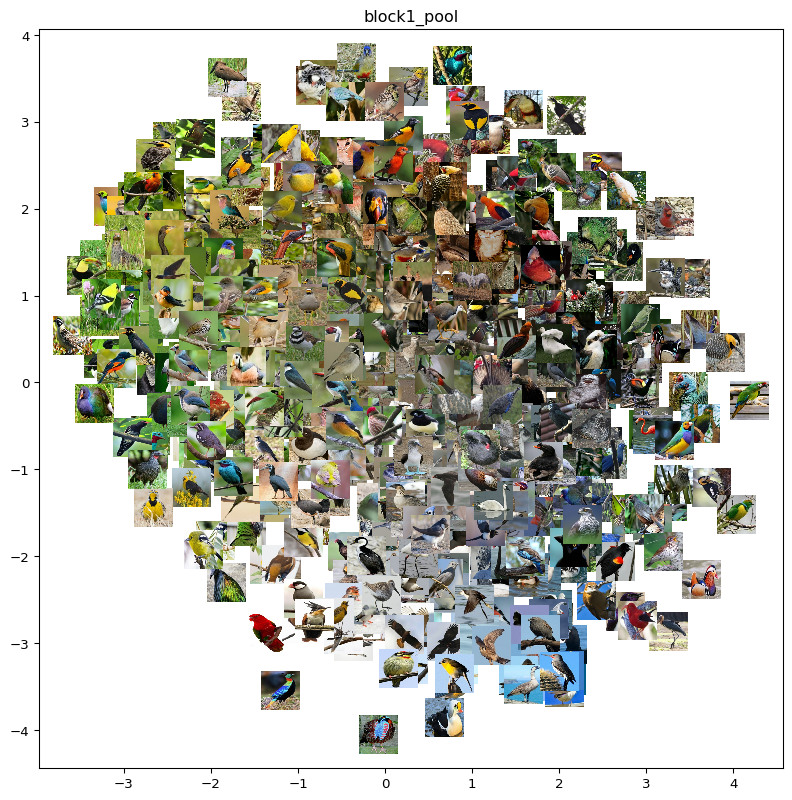

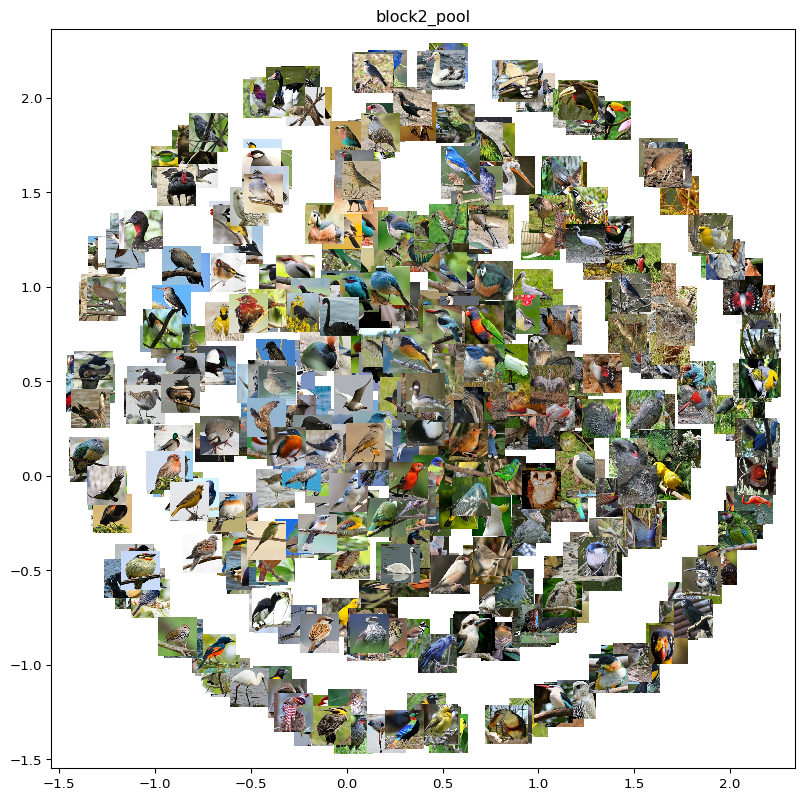

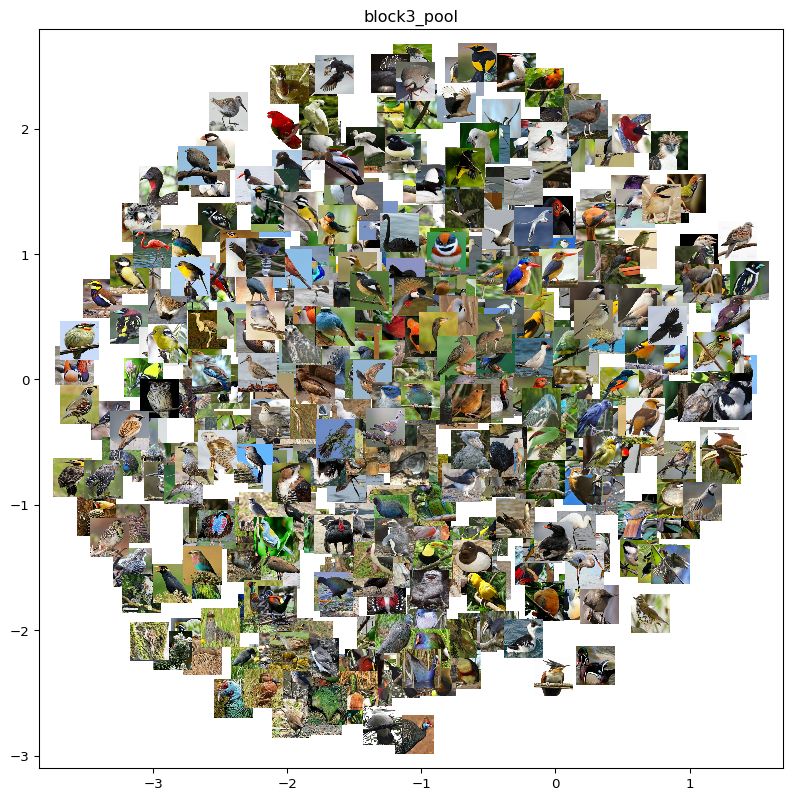

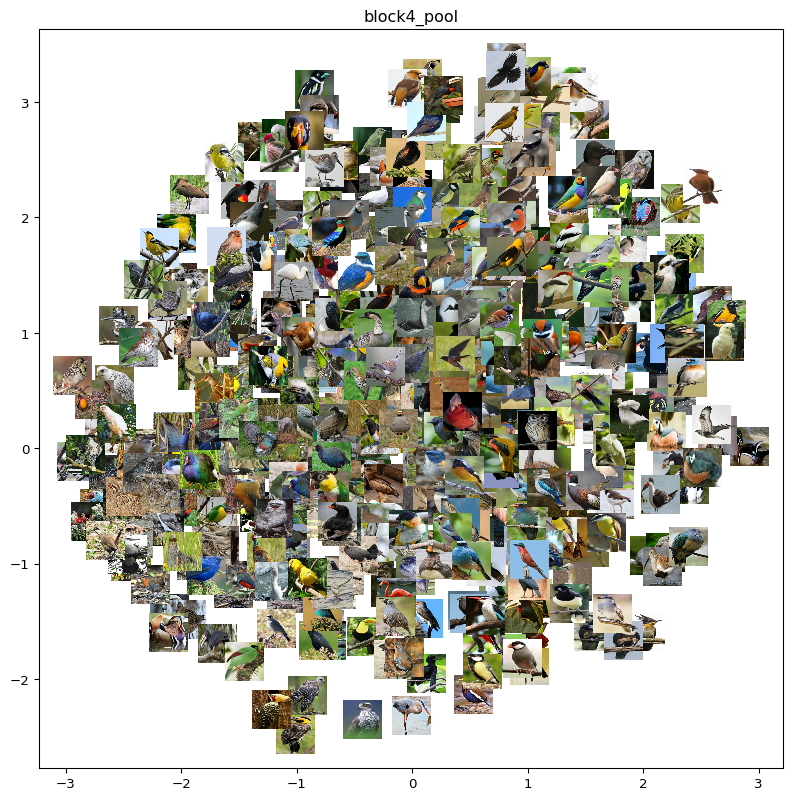

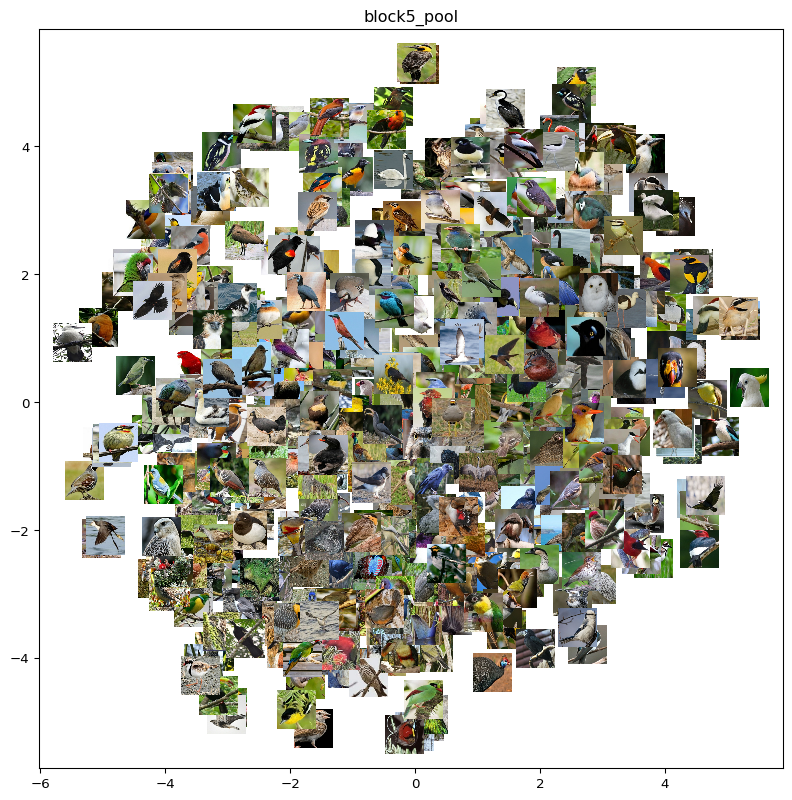

2024-02-27 21:31:25.646771: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-02-27 21:31:25.649080: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


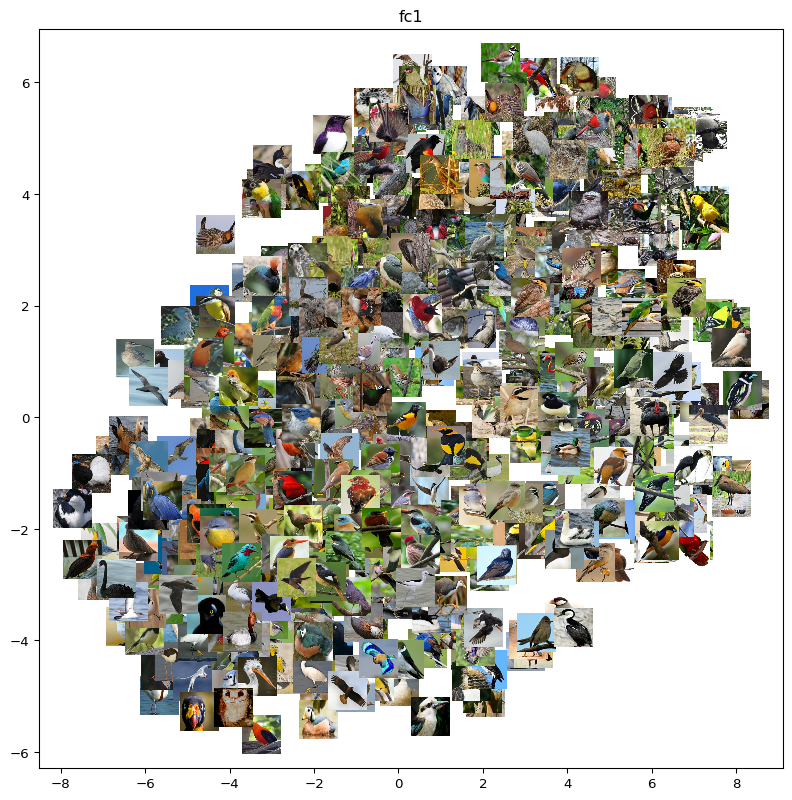

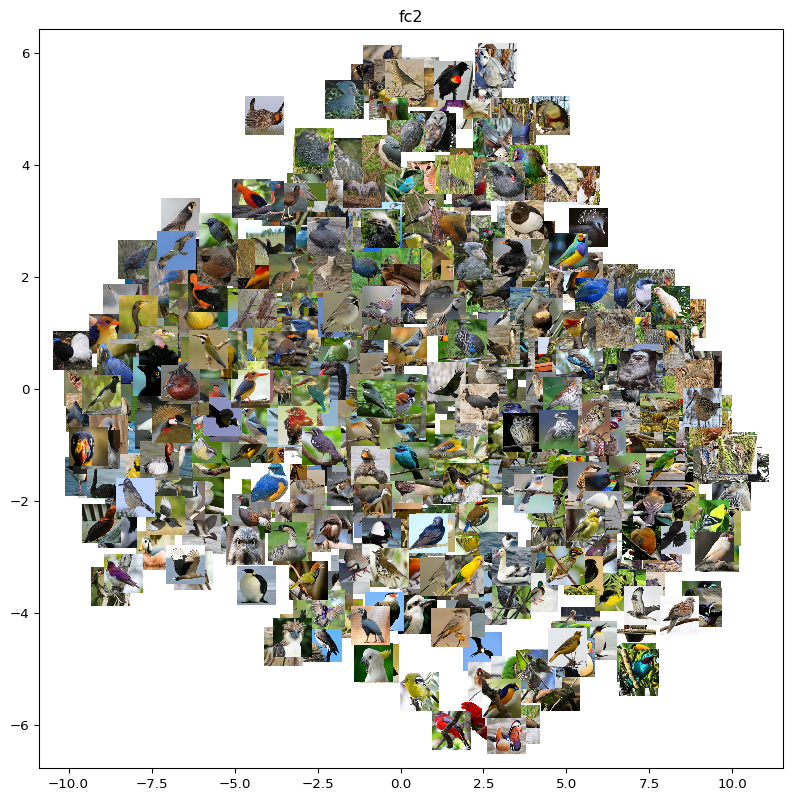

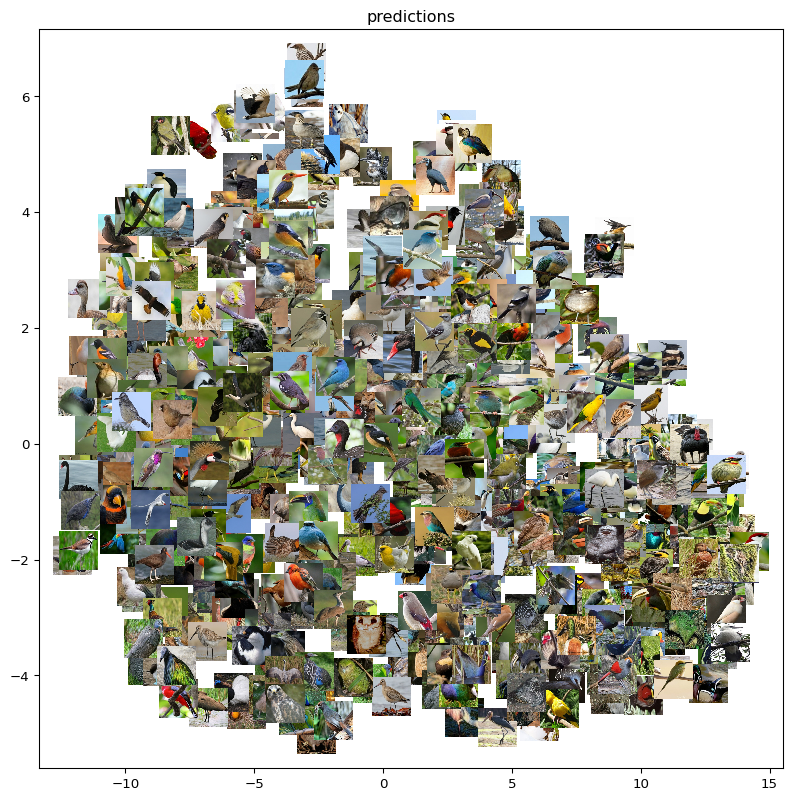

In [8]:
with strategy.scope():
    # Each model with different output.
    for i, m in enumerate(models):

        fig = plt.figure(figsize=(10, 2 * 5), dpi=96)

        batch_iter = iter(train_images)
        latent_init_value = []
        images = []

        # Extract each image latent space, iterative, since doing it with all data at once, cause it to allocate to much data...?
        for data_image_batch in batch_iter:
            latent = np.asarray(m.predict(preprocess_input(data_image_batch), verbose=0))
            for l in latent:
                latent_init_value.append(l)
            for im in data_image_batch:
                images.append(im)

        # Combine the latent space and reshape where the dim[0] == number of images, the rest the features.
        latent_value = np.asarray(latent_init_value)
        latent_value = latent_value.reshape(latent_value.shape[0], np.product(latent_value.shape[1:]))

        if len(latent_value[0]) > 1:

            tsne = TSNE(n_components=2, init='pca', n_iter=2000, perplexity=100,
                        random_state=0, learning_rate='auto')
            X_tsne = tsne.fit_transform(latent_value)
            imscatter(X_tsne[:, 0], X_tsne[:, 1], images, zoom=0.15, ax=fig)
            plt.title(str.format("{0}", selected_layers[i]))

            plt.scatter(X_tsne[:, 0], X_tsne[:, 1])

        plt.show(block=False)
        fig.savefig(str.format("output{0}.png", i))